# H2O.ai GPU Edition Machine Learning $-$ Multi-GPU GLM Demo

### In this demo, we will train 4000 regularized linear regression models (aka Generalized Linear Models or GLMs) on the U.S. Census dataset, with the goal to predict the earned income of a person, given approximately 10000 features such as gender, age, occupation, zip code, etc.

### The dataset is about 2GB in memory (50k rows, 10k cols, single-precision floating-point values), so it easily fits onto the GPU memory.

### By using multiple GPUs, we are able to speed up this process significantly, and can train about 40 models per second (on a DGX-1 with 8 GPUs) vs 1 model per second on dual-Xeon server.

### Import Dependencies

In [1]:
## First time only: Install dependencies
#!pip install https://s3.amazonaws.com/h2o-beta-release/goai/h2o4gpu-0.0.2-py2.py3-none-any.whl
#!pip install Cython pandas seaborn psutil feather_format
#!pip install -e "git+https://github.com/fbcotter/py3nvml#egg=py3nvml"

## Now restart the kernel to get py3nvml to work

In [2]:
%reset -f
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Import Data Frame and create raw X and y arrays

In [3]:
import os, sys, time
import feather

if not os.path.exists("ipums_feather"):
   !wget https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/ipums_feather.gz
   !gunzip ipums_feather.gz
t0 = time.time()
df = feather.read_dataframe("ipums_feather")
t1 = time.time()
print("Time to read data via feather: %r" % (t1-t0))

Time to read data via feather: 1.013885498046875


In [4]:
## We predict the last column "INCEARN" - Income earned
target = df.columns[-1]
cols = [c for c in df.columns if c != target]

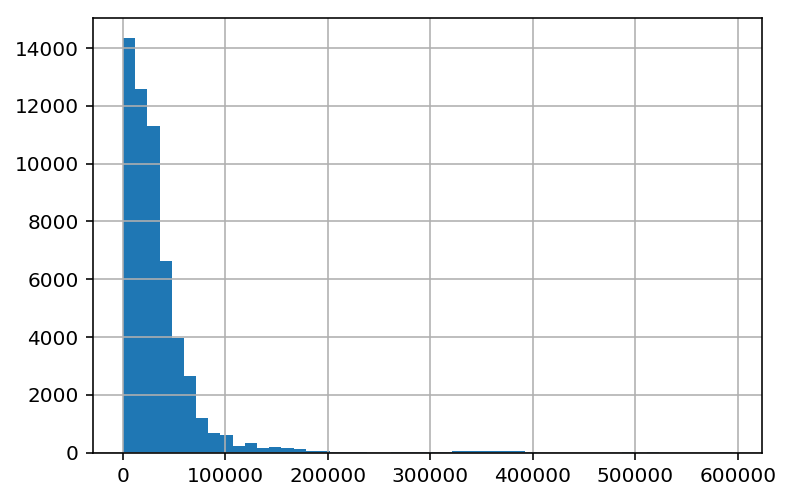

In [5]:
df[target].hist(bins=50)

In [6]:
import numpy as np

X = np.array(df.ix[:,cols], order='f').astype('float32')
y = np.array(df[target].values, dtype='float32')
print(X.shape)
print(y.shape)

(55776, 9732)
(55776,)


### Split the dataset into Training (80%) and Validation (20%)

In [7]:
intercept = True
validFraction=0.2
standardize = 0
lambda_min_ratio = 1e-7

if standardize:
    print ("implement standardization transformer")
    exit()

# Setup Train/validation Set Split
morig = X.shape[0]
norig = X.shape[1]
fortran = X.flags.f_contiguous
print("fortran order=%d" % (fortran))
print("Original data rows=%d cols=%d" % (morig,norig))

# Do train/valid split
HO=int(validFraction*morig)
H=morig-HO
print("Training  rows=%d" % (H))
print("Vaidation rows=%d" % (HO))
trainX = np.copy(X[0:H,:])
trainY = np.copy(y[0:H])
validX = np.copy(X[H:morig,:])
validY = np.copy(y[H:morig])
trainW = np.copy(trainY)*0.0 + 1.0 # constant unity weight

mTrain = trainX.shape[0]
mvalid = validX.shape[0]

# if using upload_data and fit_ptr, then have to create own intercept as last column in trainX and validX
if intercept:
    trainX = np.hstack([trainX, np.ones((trainX.shape[0],1),dtype=trainX.dtype)])
    validX = np.hstack([validX, np.ones((validX.shape[0],1),dtype=validX.dtype)])
    n = trainX.shape[1]
print("New data rows=%d cols=%d" % (mTrain,n))

fortran order=1
Original data rows=55776 cols=9732
Training  rows=44621
Vaidation rows=11155
New data rows=44621 cols=9733


### Define some helper methods for plotting and running the algorithm

In [8]:
import seaborn as sns
sns.set_style("whitegrid")

def new_alpha(row_fold):
    if row_fold == 0:
        return -0.025
    elif row_fold == 1:
        return -0.05
    elif row_fold == 3:
        return 0.025
    elif row_fold == 4:
        return 0.05
    else: return 0

def plot_cpu_perf(axis, cpu_labels, cpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(cpu_labels, cpu_snapshot, color='dodgerblue', edgecolor='none')
    axis.set_title('CPU Utilization', fontsize = 16)
    
def plot_gpu_perf(axis, gpu_labels, gpu_snapshot):
    axis.cla()
    axis.grid(False)
    axis.set_ylim([0,100])
    axis.set_xticks(gpu_labels)
    axis.set_ylabel('Percent', labelpad=2, fontsize = 14)
    axis.bar(gpu_labels, gpu_snapshot, width =0.5, color = 'limegreen',align='center', edgecolor='none')
    axis.set_title('GPU Utilization', fontsize = 16)
    
def plot_glm_results(axis, results, best_rmse, cb):
    axis.cla()
    axis.set_xscale('log')
    axis.set_xlim([1e2, 1e9])
    axis.set_ylim([-0.12, 1.12])
    axis.set_yticks([x/7. for x in range(0,8)])
    axis.set_ylabel('Parameter 1:  '+r'$\alpha$', fontsize = 16)
    axis.set_xlabel('Parameter 2:  '+r'$\lambda$', fontsize = 16)
    num_models = min(4000,int(4000*results.shape[0]/2570))
    axis.set_title('Elastic Net Models Trained and Evaluated: ' + str(num_models), fontsize = 16)

    try:
        from matplotlib.colors import ListedColormap
        cm = ListedColormap(sns.color_palette("RdYlGn", 10).as_hex())
        cf = axis.scatter(results['lambda'], results['alpha_prime'], c=results['rel_acc'], 
                    cmap=cm, vmin=0, vmax=1, s=60, lw=0)
        axis.plot(best_rmse['lambda'],best_rmse['alpha_prime'], 'o',
            ms=15, mec='k', mfc='none', mew=2)

        if not cb:
            cb = pl.colorbar(cf, ax=axis)
            cb.set_label('Relative  Validation  Accuracy', rotation=270, 
                         labelpad=18, fontsize = 16)   
        cb.update_normal(cf)
    except:
        #print("plot_glm_results exception -- no frame")
        pass
    
def RunAnimation(arg):
    import os, sys, time
    import subprocess
    import psutil
    import pylab as pl
    from IPython import display
    import matplotlib.gridspec as gridspec
    import seaborn as sns
    import pandas as pd
    import numpy as np
    

    print("RunAnimation")
    sys.stdout.flush()
    
    deviceCount = arg
    # Need this only for animation of GPU usage to be consistent with 
    #from py3nvml.py3nvml import *
    import py3nvml
    maxNGPUS = int(subprocess.check_output("nvidia-smi -L | wc -l", shell=True))
    print("\nNumber of GPUS:", maxNGPUS)

    py3nvml.py3nvml.nvmlInit()
    total_deviceCount = py3nvml.py3nvml.nvmlDeviceGetCount()
    if deviceCount == -1:
        deviceCount = total_deviceCount
    #for i in range(deviceCount):
    #    handle = nvmlDeviceGetHandleByIndex(i)
    #    print("Device {}: {}".format(i, nvmlDeviceGetName(handle)))
    #print ("Driver Version:", nvmlSystemGetDriverVersion())
    print("Animation deviceCount=%d" % (deviceCount))
    
    file = os.getcwd() + "/error.txt"
    print("opening %s" % (file))
    fig = pl.figure(figsize = (9,9))
    pl.rcParams['xtick.labelsize'] = 14
    pl.rcParams['ytick.labelsize'] = 14
    gs = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.4)
    ax1 = pl.subplot(gs[0,-2])
    ax2 = pl.subplot(gs[0,1])
    ax3 = pl.subplot(gs[1:,:])
    fig.suptitle('H2O.ai Machine Learning $-$ Generalized Linear Modeling', size=18)

    pl.gcf().subplots_adjust(bottom=0.2)

    #cb = False
    from matplotlib.colors import ListedColormap
    cm = ListedColormap(sns.color_palette("RdYlGn", 10).as_hex())
    cc = ax3.scatter([0.001, 0.001], [0,0], c =[0,1], cmap = cm)
    cb = pl.colorbar(cc, ax=ax3)
    os.system("mkdir -p images")
    i=0
    while(True):
        #try:
            #print("In try i=%d" % i)
            #sys.stdout.flush()
            
            #cpu
            snapshot = psutil.cpu_percent(percpu=True)
            cpu_labels = range(1,len(snapshot)+1)
            plot_cpu_perf(ax1, cpu_labels, snapshot)
    
            #gpu
            gpu_snapshot = []
            gpu_labels = list(range(1,deviceCount+1))
            import py3nvml
            for j in range(deviceCount):
                handle = py3nvml.py3nvml.nvmlDeviceGetHandleByIndex(j)
                util = py3nvml.py3nvml.nvmlDeviceGetUtilizationRates(handle)
                gpu_snapshot.append(util.gpu)
            gpu_snapshot = gpu_snapshot   
            plot_gpu_perf(ax2, gpu_labels, gpu_snapshot)
    
            res = pd.read_csv(file, sep="\s+",header=None,names=['time','pass','fold','a','i','alpha','lambda','trainrmse','ivalidrmse','validrmse'])
            
            res['rel_acc'] = ((42665- res['validrmse'])/(42665-31000))
            res['alpha_prime'] = res['alpha'] + res['fold'].apply(lambda x: new_alpha(x))

            best = res.ix[res['rel_acc']==np.max(res['rel_acc']),:]
            plot_glm_results(ax3, res, best.tail(1), cb)
            # flag for colorbar to avoid redrawing
            #cb = True

            # Add footnotes
            footnote_text = "*U.S. Census dataset (predict Income): 45k rows, 10k cols\nParameters: 5-fold cross-validation, " + r'$\alpha = \{\frac{i}{7},i=0\ldots7\}$' + ", "\
   'full $\lambda$-' + "search"
            #pl.figtext(.05, -.04, footnote_text, fontsize = 14,)
            pl.annotate(footnote_text, (0,0), (-30, -50), fontsize = 12,
                        xycoords='axes fraction', textcoords='offset points', va='top')

            #update the graphics
            display.display(pl.gcf())
            display.clear_output(wait=True)
            time.sleep(0.01)

            #save the images
            saveimage=0
            if saveimage:
                file_name = './images/glm_run_%04d.png' % (i,)
                pl.savefig(file_name, dpi=200)
            i=i+1
        
        #except KeyboardInterrupt:
        #    break
        #except:
        #    #print("Could not Create Frame")
        #    pass
        
def RunH2Oaiglm(arg):
    import h2o4gpu as h2o4gpu

    intercept, lambda_min_ratio, nFolds, n_alphas, n_lambdas, n_gpus = arg
    
    print("Begin Setting up Solver")
    os.system("rm -f error.txt ; touch error.txt ; rm -f varimp.txt ; touch varimp.txt") ## for visualization
    enet = h2o4gpu.GLM(n_gpus=n_gpus, fit_intercept=intercept, lambda_min_ratio=lambda_min_ratio, n_lambdas=n_lambdas, n_folds=n_folds, n_alphas=n_alphas)
    print("End Setting up Solver")

    ## First, get backend pointers
    sourceDev=0
    t0 = time.time()
    a,b,c,d,e = enet.upload_data(trainX, trainY, validX, validY, trainW, source_dev=sourceDev)
    t1 = time.time()
    print("Time to ingest data: %r" % (t1-t0))

    ## Solve
    if 1==1:
        print("Solving")
        t0 = time.time()
        order='c' if fortran else 'r'
        double_precision=0 # Not used
        store_full_path=0
        enet.fit_ptr(mTrain, n, mvalid, double_precision, order, a, b, c, d, e, source_dev=sourceDev)
        t1 = time.time()
        print("Done Solving")
        print("Time to train H2O AI GLM: %r" % (t1-t0))

### Train 4000 Elastic Net Models (5-fold cross-validation, 8 $\alpha$ values, 100 $\lambda$ values)

In [9]:
import subprocess
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

lambda_min_ratio=1E-9
n_folds=5
n_alphas=8
n_lambdas=100
n_gpus=-1 # -1 means use all GPUs

arg = intercept, lambda_min_ratio, n_folds, n_alphas, n_lambdas, n_gpus
from threading import Thread
background_thread = Thread(target=RunH2Oaiglm, args=(arg,))
background_thread.start()
#futures = []
#Executor = ProcessPoolExecutor(max_workers=1)
#futures.append(Executor.submit(RunH2Oaiglm, arg)) ## run in separate process

In [10]:
#RunAnimation(n_gpus)
#concurrent.futures.wait(futures)

Begin Setting up Solver
End Setting up Solver


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/jon/.pyenv/versions/3.6.1/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jon/.pyenv/versions/3.6.1/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-b157d5a006ad>", line 180, in RunH2Oaiglm
    a,b,c,d,e = enet.upload_data(trainX, trainY, validX, validY, trainW, source_dev=sourceDev)
  File "/home/jon/.pyenv/versions/3.6.1/lib/python3.6/site-packages/h2o4gpu/solvers/elastic_net.py", line 1448, in upload_data
    c_int(self.ord),
TypeError: an integer is required (got type NoneType)

